# Predicting HIV Prevalence in Kenya: A Logistic Regression Approach Using Socioeconomic and Health System Indicators

### Research Problem:
Determine which socioeconomic and health system factors are the strongest predictors of high HIV prevalence across different regions or time periods in Kenya.

Step 3: Data Loading and Initial Merging
Tools to use: Pandas is for data manipulation, matplotlib and seaborn are for visualization, scikit-learn is for machine learning, and scipy is for scientific computing.

In [1]:
# Step 3: Data Loading and Initial Merging
# ==========================================

# 1. Import the pandas library. We'll call it 'pd' for short, which is the convention.
#    This library gives us the tools to work with dataframes.
import pandas as pd

# 2. Load the CSV files into pandas DataFrames.
print("Loading data...")
df_finance = pd.read_csv(r"health_financing_indicators_ken.csv")  
df_hiv = pd.read_csv(r"hiv_indicators_ken.csv")                  
df_systems = pd.read_csv(r"health_systems_indicators_ken.csv")    
df_workforce = pd.read_csv(r"health_workforce_indicators_ken.csv")
df_uhc = pd.read_csv(r"universal_health_coverage_uhc_sdg_target_3_8_indicators_ken.csv") 
df_tobacco = pd.read_csv(r"tobacco_control_indicators_ken.csv") 
print("Data loaded successfully!")

# 3. Let's take a quick look at the HIV data to confirm the column names.
#    The .head() method shows us the first 5 rows of the dataframe.
print("\n--- First 5 rows of HIV data ---")
print(df_hiv.head())

# 4. Let's also check the column names of the HIV data to be absolutely sure.
#    The .columns attribute gives us a list of all column names.
print("\n--- Column names in HIV data ---")
print(df_hiv.columns.tolist())

# 5. Now, let's filter the HIV data to only keep the rows for the adult prevalence indicator.
#    Based on the file content, the indicator we want is 'Prevalence of HIV among adults aged 15 to 49 (%)'.
#    We'll create a new dataframe called 'df_hiv_prevalence' that only contains rows where the
#    'GHO (DISPLAY)' column matches that exact name.
df_hiv_prevalence = df_hiv[df_hiv['GHO (DISPLAY)'] == 'Prevalence of HIV among adults aged 15 to 49 (%)'].copy()

# 6. Let's see what we have. How many rows? What are the unique years?
print("\n--- Filtered HIV Prevalence Data ---")
print(f"Number of rows: {len(df_hiv_prevalence)}")
print("Unique years in this filtered data:")
print(df_hiv_prevalence['YEAR (DISPLAY)'].unique())

# 7. Now, let's do a test merge with the health financing data.
#    We will merge on the year. Both dataframes have a 'YEAR (DISPLAY)' column.
#    'how='inner'' means we only keep rows where the year exists in BOTH dataframes.
print("\n--- Performing test merge with Health Financing data ---")
df_merged_test = pd.merge(df_hiv_prevalence, df_finance, on='YEAR (DISPLAY)', how='inner', suffixes=('_hiv', '_fin'))

# 8. Let's see the result of the merge.
print(f"Number of rows in merged data: {len(df_merged_test)}")
print("Columns in merged data (first 10):")
print(df_merged_test.columns.tolist()[:10])  # Show first 10 column names

print("\nStep 3 (part 1) complete.")

Loading data...
Data loaded successfully!

--- First 5 rows of HIV data ---
       GHO (CODE)                                      GHO (DISPLAY)  \
0          SDGHIV  New HIV infections (per 1000 uninfected popula...   
1  HIV_0000000026                       Number of new HIV infections   
2  MDG_0000000029   Prevalence of HIV among adults aged 15 to 49 (%)   
3  HIV_0000000009  Reported number of people receiving antiretrov...   
4  HIV_0000000021  Estimated number of pregnant women living with...   

                                           GHO (URL)  YEAR (DISPLAY)  \
0  https://www.who.int/data/gho/data/indicators/i...            1993   
1  https://www.who.int/data/gho/data/indicators/i...            2016   
2  https://www.who.int/data/gho/data/indicators/i...            2014   
3  https://www.who.int/data/gho/data/indicators/i...            2020   
4  https://www.who.int/data/gho/data/indicators/i...            2011   

   STARTYEAR  ENDYEAR REGION (CODE) REGION (DISPLAY) COUNT

Analysis of the Findings:

1. HIV Prevalence Data (df_hiv_prevalence):
Number of rows (25): This tells us we have 25 data points for our target variable (adult HIV prevalence). This is our sample size for the model. It's not huge, which is good to know for later when we think about model limitations.

2. Unique years (25 unique years): This is a crucial finding. It means we have only one HIV prevalence value per year. We don't have data for different regions or sub-populations within a year. This means our analysis will be at the national level, over time. Each row in our final dataset will represent a single year.

3. Merged Data (df_merged_test):Number of rows (288): This is much larger than 25. Why? Because the health_financing_indicators_ken.csv file contains multiple rows for the same year (different financing indicators). For example, for the year 2017, there might be one row for "Domestic private health expenditure per capita" and another row for "Domestic general government health expenditure as % of government expenditure". When we merge, we get a new row for every combination of an HIV prevalence row and a financing indicator row. So, for the year 2014 (which has 1 HIV prevalence row), if there are, say, 10 financing indicator rows for 2014, the merge will create 10 rows for 2014 in the merged data. That's why we get 288 rows (which is roughly 25 years * an average of 11-12 financing indicators per year).

This is exactly as expected and shows our merge worked correctly. However, this format (one row per indicator per year) is not yet ready for modeling. For a logistic regression, we need one row per year, with each financing indicator as its own separate column.

This leads us to the next critical step: reshaping the data.

### Step 3 (Part 2): Reshaping the Data (Pivot Tables)
We are going to transform our data from a "long" format (many rows per year) to a "wide" format (one row per year, with many columns). This is done using a pivot operation.

Why we are doing this:
Think of it like this:
Current format (long): Each row is a single observation of a single variable. It's like a list: "In 2014, CHE as % of GDP was 4.9", "In 2014, OOP as % of CHE was 30.2". This is efficient for data storage but not for analysis.
Desired format (wide): Each row is a single observation (a year) with all its variables as columns. It's like a table: A single row for 2014 with columns for CHE_GDP, OOP_CHE, GGHE_GGE, etc. This is what we need for our regression model, where each column is a potential predictor (X) and we have one row per observation.
We will perform this pivot operation on the health financing data first, then merge it with the HIV prevalence data.

In [2]:
# Step 3 (Part 2): Reshaping the Health Financing Data
# =====================================================

# 1. First, let's remind ourselves what the health financing data looks like.
#    We'll look at a few rows for a specific year, say 2017, to see the long format.
print("\n--- Health Financing data for 2017 (long format) ---")
df_finance_2017 = df_finance[df_finance['YEAR (DISPLAY)'] == 2017]
print(df_finance_2017[['YEAR (DISPLAY)', 'GHO (DISPLAY)', 'Numeric']].head(10))

# 2. Now, we will pivot the table.
#    - index='YEAR (DISPLAY)': This means each unique year will become a row.
#    - columns='GHO (DISPLAY)': This means each unique value in the 'GHO (DISPLAY)' column
#      (i.e., each unique indicator name) will become a new column.
#    - values='Numeric': This means the cells of the new table will be filled with the
#      values from the 'Numeric' column.
#    The .reset_index() method makes sure 'YEAR (DISPLAY)' remains a column and doesn't become just an index.
print("\n--- Pivoting Health Financing data to wide format ---")
df_finance_wide = df_finance.pivot(index='YEAR (DISPLAY)', 
                                    columns='GHO (DISPLAY)', 
                                    values='Numeric').reset_index()

# 3. Let's examine the result.
print(f"\nShape of pivoted financing data: {df_finance_wide.shape}")  # (rows, columns)
print("\nFirst 5 rows of pivoted financing data:")
print(df_finance_wide.head())

# 4. Check the column names. They should now be the names of the indicators.
print("\nColumn names of pivoted financing data (first 10):")
print(df_finance_wide.columns.tolist()[:10])

# 5. Now, we have our HIV prevalence data (df_hiv_prevalence) which is also in a format
#    where each row is a year and an indicator, but we only have one indicator.
#    We need to pivot this too, to make sure it's in the same wide format.
#    However, since we only have one indicator, pivoting is simple.
print("\n--- Pivoting HIV Prevalence data ---")
df_hiv_wide = df_hiv_prevalence.pivot(index='YEAR (DISPLAY)', 
                                       columns='GHO (DISPLAY)', 
                                       values='Numeric').reset_index()

print(f"\nShape of pivoted HIV data: {df_hiv_wide.shape}")
print("\nFirst 5 rows of pivoted HIV data:")
print(df_hiv_wide.head())

# 6. Finally, let's merge these two wide-format dataframes.
#    We merge on the 'YEAR (DISPLAY)' column.
print("\n--- Merging wide-format HIV and Financing data ---")
df_merged_wide = pd.merge(df_hiv_wide, df_finance_wide, on='YEAR (DISPLAY)', how='inner')

print(f"\nShape of final merged wide data: {df_merged_wide.shape}")
print("\nFirst 5 rows and a few columns of the final merged data:")
# Select a few columns to display to avoid clutter
cols_to_show = ['YEAR (DISPLAY)', 
                'Prevalence of HIV among adults aged 15 to 49 (%)',
                'Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)',
                'Out-of-pocket expenditure (OOP) per capita in US$']
# Check if these columns exist before printing
existing_cols_to_show = [col for col in cols_to_show if col in df_merged_wide.columns]
print(df_merged_wide[existing_cols_to_show].head())

print("\nStep 3 (Part 2) complete.")


--- Health Financing data for 2017 (long format) ---
     YEAR (DISPLAY)                                      GHO (DISPLAY)  \
0              2017  Domestic private health expenditure (PVT-D) pe...   
5              2017  Domestic general government health expenditure...   
28             2017  Current health expenditure (CHE) per capita in...   
35             2017  Domestic private health expenditure (PVT-D) as...   
83             2017  Domestic general government health expenditure...   
135            2017  Out-of-pocket expenditure (OOP) per capita in US$   
169            2017  Out-of-pocket expenditure as percentage of cur...   
171            2017  External health expenditure (EXT) per capita i...   
190            2017  Domestic general government health expenditure...   
201            2017  Current health expenditure (CHE) as percentage...   

       Numeric  
0    23.910043  
5     6.792405  
28   66.465523  
35   35.973606  
83   42.939667  
135  15.473571  
169  23.2806

Analysis of the Findings:
1. Health Financing data for 2017 (long format): This confirms our understanding. Multiple rows for the same year, each with a different indicator. For example, in 2017 we have rows for:
- Domestic private health expenditure per capita (23.91)
- Domestic general government health expenditure as % of government expenditure (6.79%)
- Current health expenditure per capita (66.47)
And many more...

2. Pivoted financing data shape (24, 13): This is a crucial finding.
- 24 rows: This means we have health financing data for 24 unique years. But earlier, the HIV data had 25 unique years (2000-2024). This tells us there's one year (likely 2024) for which we have HIV data but NO health financing data. This is important for our merge.
- 13 columns: This means there are 13 different health financing indicators that have been pivoted into separate columns. Perfect!

3. Pivoted HIV data shape (25, 2): This is exactly as expected. 25 rows (one per year) and 2 columns (Year and HIV Prevalence). Good.
4. Final merged wide data shape (24, 14): This is the key result.
- 24 rows: Because we used how='inner' in the merge, we only kept years that exist in BOTH datasets. Since the financing data only has 24 years (missing 2024), our merged dataset has 24 years (2000-2023, presumably). This is our final sample size for modeling: 24 observations. This is small, but workable.
- 14 columns: 1 year column + 1 HIV prevalence column + 12 financing indicator columns (since the financing data had 13 columns including year, so 12 indicators).

In [3]:
# Check the years in our final merged dataset
print("\n--- Years in final merged dataset ---")
print(df_merged_wide['YEAR (DISPLAY)'].tolist())
print(f"Number of years: {len(df_merged_wide['YEAR (DISPLAY)'])}")


--- Years in final merged dataset ---
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of years: 24


### Step 4: Adding Health Systems Indicators
What we're doing:
We're going to repeat the exact same process we used for the financing data, but now with the Health Systems Indicators dataset. We'll pivot it to wide format and then merge it with our existing merged dataframe.

In [5]:
# Step 4 : Adding Health Systems Indicators
# =====================================================

# 1. First, let's see what values are in the DIMENSION (NAME) column
print("\n--- Unique values in DIMENSION (NAME) column ---")
print(df_systems['DIMENSION (NAME)'].unique())

# 2. Filter to keep only rows where DIMENSION (NAME) is 'Total'
#    Also keep rows where DIMENSION (NAME) is NaN (these are the density indicators without breakdowns)
print("\n--- Filtering to keep only total values ---")
df_systems_filtered = df_systems[
    (df_systems['DIMENSION (NAME)'].isna()) |  # Keep rows with no dimension (like hospital density)
    (df_systems['DIMENSION (NAME)'] == 'Total')  # Keep rows where dimension is 'Total'
].copy()

print(f"Original rows: {len(df_systems)}")
print(f"Filtered rows: {len(df_systems_filtered)}")

# 3. Now let's check if we still have duplicates
print("\n--- Checking for duplicates after filtering ---")
# Group by year and indicator to see counts
duplicate_check = df_systems_filtered.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size()
print("Rows per year-indicator combination after filtering:")
print(duplicate_check[duplicate_check > 1])  # This should be empty

# 4. Now pivot should work
print("\n--- Pivoting Health Systems Data ---")
df_systems_wide = df_systems_filtered.pivot(index='YEAR (DISPLAY)', 
                                            columns='GHO (DISPLAY)', 
                                            values='Numeric').reset_index()

print(f"\nShape of pivoted health systems data: {df_systems_wide.shape}")
print("\nFirst 5 rows of pivoted health systems data:")
print(df_systems_wide.head())

# 5. Check the column names
print("\nColumn names in pivoted health systems data:")
print(df_systems_wide.columns.tolist())

# 6. Now merge this with our existing merged dataframe
print("\n--- Merging Health Systems data with our existing dataset ---")
df_merged_wide = pd.merge(df_merged_wide, df_systems_wide, on='YEAR (DISPLAY)', how='left')

print(f"\nShape of merged data after adding health systems: {df_merged_wide.shape}")
print("\nFirst 5 rows of updated merged data (showing first few columns):")
print(df_merged_wide.iloc[:, :8].head())

# 7. Check how many new columns were added
print(f"\nTotal columns now: {len(df_merged_wide.columns)}")


--- Unique values in DIMENSION (NAME) column ---
['Outpatient' 'Inpatient' nan 'Q1 (Poorest)' 'Q5 (Richest)' 'Q2' 'Total'
 'Q4' 'Q3']

--- Filtering to keep only total values ---
Original rows: 36
Filtered rows: 18

--- Checking for duplicates after filtering ---
Rows per year-indicator combination after filtering:
YEAR (DISPLAY)  GHO (DISPLAY)                                         
2014            Care-seeking by type of patient and source of care (%)    4
dtype: int64

--- Pivoting Health Systems Data ---


ValueError: Index contains duplicate entries, cannot reshape

In [6]:
# Step 4 (Debugging): Identifying Duplicate Entries
# ==================================================

# 1. First, let's see all the unique values in DIMENSION (NAME) again
print("\n--- All unique values in DIMENSION (NAME) ---")
print(df_systems['DIMENSION (NAME)'].unique())

# 2. Let's look at rows for a specific indicator that might have duplicates
print("\n--- Checking 'Hospital beds (per 10 000 population)' indicator ---")
hospital_beds = df_systems[df_systems['GHO (DISPLAY)'] == 'Hospital beds (per 10 000 population)']
print(hospital_beds[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'Numeric', 'Value']])

# 3. Let's do a systematic check for all duplicates
print("\n--- Finding all duplicate year-indicator combinations ---")
# Group by year and indicator, count rows
duplicate_check = df_systems.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates = duplicate_check[duplicate_check['count'] > 1]
print(f"Number of duplicate year-indicator combinations: {len(duplicates)}")
print("\nDuplicate combinations:")
print(duplicates)

# 4. Let's look at one specific duplicate to understand why it's happening
if len(duplicates) > 0:
    first_duplicate = duplicates.iloc[0]
    year = first_duplicate['YEAR (DISPLAY)']
    indicator = first_duplicate['GHO (DISPLAY)']
    
    print(f"\n--- Examining first duplicate: Year {year}, Indicator '{indicator}' ---")
    duplicate_rows = df_systems[(df_systems['YEAR (DISPLAY)'] == year) & 
                                 (df_systems['GHO (DISPLAY)'] == indicator)]
    print(duplicate_rows[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'Numeric', 'Value']])

# 5. Alternative approach: Instead of filtering by 'Total', let's explicitly
#    exclude rows with specific dimensions we don't want
print("\n--- Alternative filtering approach ---")
# List of dimension names we want to EXCLUDE (patient types, wealth quintiles)
dimensions_to_exclude = ['Outpatient', 'Inpatient', 'Q1 (Poorest)', 'Q2', 'Q3', 'Q4', 'Q5 (Richest)']

df_systems_filtered = df_systems[~df_systems['DIMENSION (NAME)'].isin(dimensions_to_exclude)].copy()
print(f"Rows after excluding specific dimensions: {len(df_systems_filtered)}")

# 6. Check again for duplicates
duplicate_check_filtered = df_systems_filtered.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates_filtered = duplicate_check_filtered[duplicate_check_filtered['count'] > 1]
print(f"Remaining duplicates after filtering: {len(duplicates_filtered)}")

# 7. If there are still duplicates, we need to see them
if len(duplicates_filtered) > 0:
    print("\nRemaining duplicate combinations:")
    print(duplicates_filtered)
    
    # Examine the first remaining duplicate
    first_dup = duplicates_filtered.iloc[0]
    year = first_dup['YEAR (DISPLAY)']
    indicator = first_dup['GHO (DISPLAY)']
    
    print(f"\n--- Examining remaining duplicate: Year {year}, Indicator '{indicator}' ---")
    duplicate_rows = df_systems_filtered[(df_systems_filtered['YEAR (DISPLAY)'] == year) & 
                                         (df_systems_filtered['GHO (DISPLAY)'] == indicator)]
    print(duplicate_rows[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'Numeric', 'Value']])


--- All unique values in DIMENSION (NAME) ---
['Outpatient' 'Inpatient' nan 'Q1 (Poorest)' 'Q5 (Richest)' 'Q2' 'Total'
 'Q4' 'Q3']

--- Checking 'Hospital beds (per 10 000 population)' indicator ---
    YEAR (DISPLAY) DIMENSION (NAME)  Numeric  Value
13            2010              NaN     14.0   14.0
21            2019              NaN     13.3   13.3
24            2004              NaN     14.0   14.0

--- Finding all duplicate year-indicator combinations ---
Number of duplicate year-indicator combinations: 1

Duplicate combinations:
    YEAR (DISPLAY)                                      GHO (DISPLAY)  count
13            2014  Care-seeking by type of patient and source of ...     22

--- Examining first duplicate: Year 2014, Indicator 'Care-seeking by type of patient and source of care (%)' ---
    YEAR (DISPLAY) DIMENSION (NAME)  Numeric  Value
0             2014       Outpatient    26.13  26.13
1             2014        Inpatient     1.74   1.74
3             2014     Q1 (Poores

In [7]:
# Step 4 (Debugging - Continued): Examining the 'Total' rows in more detail
# ==========================================================================

# 1. Look at all rows for the problematic indicator in 2014, including DIMENSION (CODE)
print("\n--- All rows for Care-seeking indicator in 2014 with dimensions ---")
care_seeking_2014 = df_systems[
    (df_systems['YEAR (DISPLAY)'] == 2014) & 
    (df_systems['GHO (DISPLAY)'] == 'Care-seeking by type of patient and source of care (%)')
]
print(care_seeking_2014[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'DIMENSION (CODE)', 'Numeric', 'Value']])

# 2. Focus specifically on the rows where DIMENSION (NAME) is 'Total'
print("\n--- 'Total' rows for Care-seeking indicator in 2014 ---")
total_rows = care_seeking_2014[care_seeking_2014['DIMENSION (NAME)'] == 'Total']
print(total_rows[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'DIMENSION (CODE)', 'Numeric', 'Value']])

# 3. Let's see what unique DIMENSION (CODE) values exist for 'Total'
print("\n--- Unique DIMENSION (CODE) for 'Total' rows ---")
print(total_rows['DIMENSION (CODE)'].unique())

# 4. Based on what we find, we need to decide which 'Total' to keep.
#    For now, let's keep all rows where DIMENSION (NAME) is NaN (like hospital beds)
#    and for the Care-seeking indicator, we'll need a special rule.
print("\n--- Creating final filtered dataset ---")

# Keep rows with NaN dimension (like hospital beds)
df_systems_nan = df_systems[df_systems['DIMENSION (NAME)'].isna()].copy()

# For the Care-seeking indicator, we need to decide. Let's look at the DIMENSION (CODE) values
# to understand what each 'Total' represents. Based on the codes:
# - CAREPATIENT_CAREPATIENT_TOT (18.58) - likely total for all patients
# - SOURCE_SOURCE_TOT (70.18) - likely total for all sources of care
# - Another SOURCE_SOURCE_TOT? (2.67) -这可能是一个错误
# - Another CAREPATIENT_CAREPATIENT_TOT? (8.57) -这可能是一个错误

# For now, let's keep only the rows where DIMENSION (CODE) contains 'TOT' (meaning total)
# and drop any exact duplicates if they exist
df_systems_care = df_systems[
    (df_systems['GHO (DISPLAY)'] == 'Care-seeking by type of patient and source of care (%)') &
    (df_systems['DIMENSION (CODE)'].str.contains('TOT', na=False))
].copy()

# Combine them
df_systems_final = pd.concat([df_systems_nan, df_systems_care], ignore_index=True)

print(f"Rows in final filtered dataset: {len(df_systems_final)}")

# 5. Check for duplicates again
duplicate_check_final = df_systems_final.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates_final = duplicate_check_final[duplicate_check_final['count'] > 1]
print(f"Remaining duplicates after final filtering: {len(duplicates_final)}")

if len(duplicates_final) > 0:
    print("\nRemaining duplicate combinations:")
    print(duplicates_final)

# 6. Now try pivoting again
print("\n--- Pivoting Health Systems Data (Final Attempt) ---")
try:
    df_systems_wide = df_systems_final.pivot(index='YEAR (DISPLAY)', 
                                              columns='GHO (DISPLAY)', 
                                              values='Numeric').reset_index()
    print(f"Success! Shape: {df_systems_wide.shape}")
    print("\nFirst 5 rows:")
    print(df_systems_wide.head())
    
    # 7. Merge with our existing data
    print("\n--- Merging with existing dataset ---")
    df_merged_wide = pd.merge(df_merged_wide, df_systems_wide, on='YEAR (DISPLAY)', how='left')
    print(f"New shape: {df_merged_wide.shape}")
    print(f"Total columns now: {len(df_merged_wide.columns)}")
    
except Exception as e:
    print(f"Pivot failed: {e}")


--- All rows for Care-seeking indicator in 2014 with dimensions ---
    YEAR (DISPLAY) DIMENSION (NAME)             DIMENSION (CODE)  Numeric  \
0             2014       Outpatient  CAREPATIENT_CAREPATIENT_OUT    26.13   
1             2014        Inpatient  CAREPATIENT_CAREPATIENT_INP     1.74   
3             2014     Q1 (Poorest)           WEALTHQUINTILE_WQ1    19.60   
4             2014     Q5 (Richest)           WEALTHQUINTILE_WQ5    45.26   
7             2014       Outpatient  CAREPATIENT_CAREPATIENT_OUT     2.51   
8             2014        Inpatient  CAREPATIENT_CAREPATIENT_INP    10.13   
10            2014               Q2           WEALTHQUINTILE_WQ2    79.03   
11            2014     Q5 (Richest)           WEALTHQUINTILE_WQ5    54.74   
14            2014            Total  CAREPATIENT_CAREPATIENT_TOT    18.58   
15            2014       Outpatient  CAREPATIENT_CAREPATIENT_OUT     3.49   
16            2014               Q2           WEALTHQUINTILE_WQ2    20.97   
17     

In [8]:
# Step 4 (Final): Adding Health Systems Indicators (Without Problematic Indicator)
# ================================================================================

# 1. First, identify all indicators EXCEPT the problematic one
print("\n--- All unique indicators in health systems data ---")
all_indicators = df_systems['GHO (DISPLAY)'].unique().tolist()
print(all_indicators)

problem_indicator = 'Care-seeking by type of patient and source of care (%)'
clean_indicators = [ind for ind in all_indicators if ind != problem_indicator]
print(f"\nKeeping {len(clean_indicators)} clean indicators:")
print(clean_indicators)

# 2. Filter to keep only rows with clean indicators AND where DIMENSION (NAME) is NaN
df_systems_clean = df_systems[
    (df_systems['GHO (DISPLAY)'].isin(clean_indicators)) & 
    (df_systems['DIMENSION (NAME)'].isna())
].copy()

print(f"\nRows in clean health systems data: {len(df_systems_clean)}")

# 3. Verify no duplicates remain
duplicate_check = df_systems_clean.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates = duplicate_check[duplicate_check['count'] > 1]
print(f"Remaining duplicates: {len(duplicates)}")
if len(duplicates) > 0:
    print("Warning: Duplicates still exist!")
    print(duplicates)

# 4. Pivot the clean data
print("\n--- Pivoting Clean Health Systems Data ---")
df_systems_wide = df_systems_clean.pivot(index='YEAR (DISPLAY)', 
                                          columns='GHO (DISPLAY)', 
                                          values='Numeric').reset_index()

print(f"Success! Shape of pivoted data: {df_systems_wide.shape}")
print("\nFirst 5 rows:")
print(df_systems_wide.head())

# 5. Check the column names
print("\nColumn names in pivoted health systems data:")
print(df_systems_wide.columns.tolist())

# 6. Merge with our existing merged dataframe
print("\n--- Merging Health Systems data with our existing dataset ---")
df_merged_wide = pd.merge(df_merged_wide, df_systems_wide, on='YEAR (DISPLAY)', how='left')

print(f"\nShape of merged data after adding health systems: {df_merged_wide.shape}")
print("\nFirst 5 rows of updated merged data (showing first few columns):")
print(df_merged_wide.iloc[:, :8].head())

# 7. Check how many new columns were added
print(f"\nTotal columns now: {len(df_merged_wide.columns)}")
print(f"Column names: {df_merged_wide.columns.tolist()}")


--- All unique indicators in health systems data ---
['Care-seeking by type of patient and source of care (%)', 'Total density per 100 000 population: District/rural hospitals', 'Total density per 100 000 population: Health posts', 'Total density per 100 000 population: Health centres', 'Total density per 100 000 population: Hospitals', 'Hospital beds (per 10 000 population)', 'Total density per 100 000 population: Provincial hospitals', 'Total density per 100 000 population: Specialized hospitals']

Keeping 7 clean indicators:
['Total density per 100 000 population: District/rural hospitals', 'Total density per 100 000 population: Health posts', 'Total density per 100 000 population: Health centres', 'Total density per 100 000 population: Hospitals', 'Hospital beds (per 10 000 population)', 'Total density per 100 000 population: Provincial hospitals', 'Total density per 100 000 population: Specialized hospitals']

Rows in clean health systems data: 14
Remaining duplicates: 0

--- Piv

In [9]:
# Step 5: Adding Health Workforce Indicators
# ==========================================

# 1. First, let's examine the workforce data structure
print("\n--- Health Workforce Data Overview ---")
print(f"Shape of workforce data: {df_workforce.shape}")
print("\nFirst 5 rows:")
print(df_workforce.head())

# 2. Check for dimension columns (like we saw in health systems)
print("\n--- Checking for dimension columns ---")
print("Columns in workforce data:")
print(df_workforce.columns.tolist())

# 3. Check if there's a DIMENSION (NAME) or similar column
if 'DIMENSION (NAME)' in df_workforce.columns:
    print("\nUnique values in DIMENSION (NAME):")
    print(df_workforce['DIMENSION (NAME)'].unique())
else:
    print("\nNo DIMENSION (NAME) column found")

# 4. Check what indicators we have
print("\n--- Unique indicators in workforce data ---")
workforce_indicators = df_workforce['GHO (DISPLAY)'].unique().tolist()
print(f"Total indicators: {len(workforce_indicators)}")
print("First 10 indicators:")
print(workforce_indicators[:10])

# 5. Check years covered
print("\n--- Years in workforce data ---")
workforce_years = sorted(df_workforce['YEAR (DISPLAY)'].unique())
print(f"Years: {workforce_years}")
print(f"Number of years: {len(workforce_years)}")

# 6. Check for potential duplicates (year-indicator combinations)
print("\n--- Checking for duplicates ---")
duplicate_check = df_workforce.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates = duplicate_check[duplicate_check['count'] > 1]
print(f"Number of duplicate year-indicator combinations: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nFirst few duplicates:")
    print(duplicates.head())
    
    # Examine one duplicate to understand why
    if len(duplicates) > 0:
        first_dup = duplicates.iloc[0]
        year = first_dup['YEAR (DISPLAY)']
        indicator = first_dup['GHO (DISPLAY)']
        
        print(f"\n--- Examining duplicate: Year {year}, Indicator '{indicator}' ---")
        duplicate_rows = df_workforce[(df_workforce['YEAR (DISPLAY)'] == year) & 
                                      (df_workforce['GHO (DISPLAY)'] == indicator)]
        
        # Show all columns to understand what's different
        print(duplicate_rows.to_string())


--- Health Workforce Data Overview ---
Shape of workforce data: (188, 17)

First 5 rows:
  GHO (CODE)                                      GHO (DISPLAY)  \
0   HWF_0024                  Community Health Workers (number)   
1   HWF_0011                                  Dentists (number)   
2   HWF_0006       Nursing and midwifery personnel (per 10,000)   
3   HWF_0022  Physiotherapy Technicians and Assistants  (num...   
4   HWF_0012          Dental Assistants and Therapists (number)   

                                           GHO (URL)  YEAR (DISPLAY)  \
0  https://www.who.int/data/gho/data/indicators/i...            2018   
1  https://www.who.int/data/gho/data/indicators/i...            2019   
2  https://www.who.int/data/gho/data/indicators/i...            2018   
3  https://www.who.int/data/gho/data/indicators/i...            2024   
4  https://www.who.int/data/gho/data/indicators/i...            2021   

   STARTYEAR  ENDYEAR REGION (CODE) REGION (DISPLAY) COUNTRY (CODE)  \
0  

In [10]:
# Step 5 (Continued): Pivot and Merge Health Workforce Indicators
# ===============================================================

# 1. Pivot the workforce data to wide format
print("\n--- Pivoting Health Workforce Data ---")
df_workforce_wide = df_workforce.pivot(index='YEAR (DISPLAY)', 
                                        columns='GHO (DISPLAY)', 
                                        values='Numeric').reset_index()

print(f"Shape of pivoted workforce data: {df_workforce_wide.shape}")
print("\nFirst 5 rows of pivoted workforce data:")
print(df_workforce_wide.head())

# 2. Check the column names
print("\nColumn names in pivoted workforce data (first 10):")
workforce_cols = df_workforce_wide.columns.tolist()
print(workforce_cols[:10])

# 3. Now merge with our existing merged dataframe
#    Use 'left' merge to keep all years from our current dataset (2000-2023)
print("\n--- Merging Workforce data with our existing dataset ---")
df_merged_wide = pd.merge(df_merged_wide, df_workforce_wide, on='YEAR (DISPLAY)', how='left')

print(f"\nShape of merged data after adding workforce: {df_merged_wide.shape}")
print(f"Total columns now: {len(df_merged_wide.columns)}")

# 4. Let's see how many workforce columns were added
#    Original columns before merge: 21
#    New total minus original = number of workforce columns added
workforce_cols_added = len(df_merged_wide.columns) - 21
print(f"Number of workforce indicators added: {workforce_cols_added}")

# 5. Quick check for missing values in the new columns
print("\n--- Checking missing values in first few workforce columns ---")
workforce_new_cols = df_merged_wide.columns[-workforce_cols_added:].tolist()[:5]  # First 5 new columns
for col in workforce_new_cols:
    missing_pct = (df_merged_wide[col].isna().sum() / len(df_merged_wide)) * 100
    print(f"{col}: {missing_pct:.1f}% missing")


--- Pivoting Health Workforce Data ---
Shape of pivoted workforce data: (19, 23)

First 5 rows of pivoted workforce data:
GHO (DISPLAY)  YEAR (DISPLAY)  Community Health Workers (number)  \
0                        2002                                NaN   
1                        2004                                NaN   
2                        2008                                NaN   
3                        2009                                NaN   
4                        2010                                NaN   

GHO (DISPLAY)  Dental Assistants and Therapists (number)  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   

GHO (DISPLAY)  Dental Prosthetic Technicians (number)  Dentists (number)  \
0                              

In [11]:
# Step 6: Adding Universal Health Coverage (UHC) Indicators
# =========================================================

# 1. First, examine the UHC data structure
print("\n--- UHC Data Overview ---")
print(f"Shape of UHC data: {df_uhc.shape}")
print("\nFirst 5 rows:")
print(df_uhc.head())

# 2. Check for dimension columns
print("\n--- Checking for dimension columns ---")
print("Columns in UHC data:")
print(df_uhc.columns.tolist())

# 3. Check DIMENSION (NAME) if it exists
if 'DIMENSION (NAME)' in df_uhc.columns:
    print("\nUnique values in DIMENSION (NAME):")
    print(df_uhc['DIMENSION (NAME)'].unique())

# 4. Check what indicators we have
print("\n--- Unique indicators in UHC data ---")
uhc_indicators = df_uhc['GHO (DISPLAY)'].unique().tolist()
print(f"Total indicators: {len(uhc_indicators)}")
for i, ind in enumerate(uhc_indicators):
    print(f"{i+1}. {ind}")

# 5. Check years covered
print("\n--- Years in UHC data ---")
uhc_years = sorted(df_uhc['YEAR (DISPLAY)'].unique())
print(f"Years: {uhc_years}")
print(f"Number of years: {len(uhc_years)}")

# 6. Check for potential duplicates
print("\n--- Checking for duplicates ---")
duplicate_check = df_uhc.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates = duplicate_check[duplicate_check['count'] > 1]
print(f"Number of duplicate year-indicator combinations: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nDuplicate combinations:")
    print(duplicates)
    
    # Examine one duplicate
    if len(duplicates) > 0:
        first_dup = duplicates.iloc[0]
        year = first_dup['YEAR (DISPLAY)']
        indicator = first_dup['GHO (DISPLAY)']
        
        print(f"\n--- Examining duplicate: Year {year}, Indicator '{indicator}' ---")
        duplicate_rows = df_uhc[(df_uhc['YEAR (DISPLAY)'] == year) & 
                                (df_uhc['GHO (DISPLAY)'] == indicator)]
        print(duplicate_rows[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'DIMENSION (CODE)', 'Numeric']])


--- UHC Data Overview ---
Shape of UHC data: (168, 17)

First 5 rows:
                          GHO (CODE)  \
0                     UHC_SCI_INFECT   
1  FINANCIALHARDSHIP_PROPORTIONOFPOP   
2                   UHC_SCI_CAPACITY   
3                 UHC_INDEX_REPORTED   
4                 UHC_INDEX_REPORTED   

                                       GHO (DISPLAY)  \
0  UHC Service Coverage sub-index on infectious d...   
1  Financial hardship in health and components (S...   
2  UHC Service Coverage sub-index on service capa...   
3             UHC Service Coverage Index (SDG 3.8.1)   
4             UHC Service Coverage Index (SDG 3.8.1)   

                                           GHO (URL)  YEAR (DISPLAY)  \
0  https://www.who.int/data/gho/data/indicators/i...            2020   
1  https://www.who.int/data/gho/data/indicators/i...            2005   
2  https://www.who.int/data/gho/data/indicators/i...            2003   
3  https://www.who.int/data/gho/data/indicators/i...           

In [12]:
# Step 6 (Continued): Clean and Pivot UHC Data
# ============================================

# 1. First, let's see all indicators and their breakdowns
print("\n--- Indicators and their breakdowns ---")
for indicator in uhc_indicators:
    print(f"\nIndicator: {indicator}")
    # Get rows for this indicator
    indicator_rows = df_uhc[df_uhc['GHO (DISPLAY)'] == indicator]
    print(f"  Total rows: {len(indicator_rows)}")
    print(f"  Unique years: {sorted(indicator_rows['YEAR (DISPLAY)'].unique())}")
    
    # Check if it has dimension breakdowns
    if 'DIMENSION (NAME)' in indicator_rows.columns:
        dim_values = indicator_rows['DIMENSION (NAME)'].dropna().unique()
        if len(dim_values) > 0:
            print(f"  Dimension values: {dim_values}")

# 2. Create a clean version - keep only rows where DIMENSION (NAME) is NaN
#    (these are the main indicators without breakdowns)
print("\n--- Creating clean UHC dataset ---")
df_uhc_clean = df_uhc[df_uhc['DIMENSION (NAME)'].isna()].copy()

print(f"Rows with no dimensions: {len(df_uhc_clean)}")
print("\nUnique indicators in clean data:")
print(df_uhc_clean['GHO (DISPLAY)'].unique())

# 3. Check for duplicates in clean data
print("\n--- Checking duplicates in clean data ---")
duplicate_check_clean = df_uhc_clean.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates_clean = duplicate_check_clean[duplicate_check_clean['count'] > 1]
print(f"Duplicates in clean data: {len(duplicates_clean)}")

if len(duplicates_clean) > 0:
    print("\nRemaining duplicates:")
    print(duplicates_clean)

# 4. Pivot the clean UHC data
print("\n--- Pivoting Clean UHC Data ---")
df_uhc_wide = df_uhc_clean.pivot(index='YEAR (DISPLAY)', 
                                  columns='GHO (DISPLAY)', 
                                  values='Numeric').reset_index()

print(f"Shape of pivoted UHC data: {df_uhc_wide.shape}")
print("\nFirst 5 rows:")
print(df_uhc_wide.head())

# 5. Check the column names
print("\nColumn names in pivoted UHC data:")
uhc_cols = df_uhc_wide.columns.tolist()
print(uhc_cols)

# 6. Now merge with our existing merged dataframe
print("\n--- Merging UHC data with our existing dataset ---")
df_merged_wide = pd.merge(df_merged_wide, df_uhc_wide, on='YEAR (DISPLAY)', how='left')

print(f"\nShape of merged data after adding UHC: {df_merged_wide.shape}")
print(f"Total columns now: {len(df_merged_wide.columns)}")

# 7. Count how many UHC columns were added
uhc_cols_added = len(df_merged_wide.columns) - 43  # 43 was previous total
print(f"Number of UHC indicators added: {uhc_cols_added}")

# 8. Quick check for missing values
print("\n--- Checking missing values in UHC columns ---")
if uhc_cols_added > 0:
    uhc_new_cols = df_merged_wide.columns[-uhc_cols_added:].tolist()
    for col in uhc_new_cols:
        missing_pct = (df_merged_wide[col].isna().sum() / len(df_merged_wide)) * 100
        print(f"{col}: {missing_pct:.1f}% missing")


--- Indicators and their breakdowns ---

Indicator: UHC Service Coverage sub-index on infectious diseases
  Total rows: 24
  Unique years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

Indicator: Financial hardship in health and components (SDG 3.8.2, 2025 definition): population (%)
  Total rows: 47
  Unique years: [np.int64(1997), np.int64(2005), np.int64(2015)]
  Dimension values: ['Impoverishing spending (Component 2)' 'Q4'
 'Adults only (20-59 years old)' 'Head of household'
 'Adults with older persons' 'Q3' 'Multigenerational households' 'Urban'
 'Rural' 'Total' 'Large spending (Component 1)'
 'Adults with children and/or adolescents' 'Q1 (Poore

In [13]:
# Step 7: Adding Tobacco Control Indicators
# =========================================

# 1. First, examine the tobacco data structure
print("\n--- Tobacco Control Data Overview ---")
print(f"Shape of tobacco data: {df_tobacco.shape}")
print("\nFirst 5 rows:")
print(df_tobacco.head())

# 2. Check for dimension columns
print("\n--- Checking for dimension columns ---")
print("Columns in tobacco data:")
print(df_tobacco.columns.tolist())

# 3. Check DIMENSION (NAME) if it exists
if 'DIMENSION (NAME)' in df_tobacco.columns:
    print("\nUnique values in DIMENSION (NAME):")
    print(df_tobacco['DIMENSION (NAME)'].unique())

# 4. Check what indicators we have
print("\n--- Unique indicators in tobacco data ---")
tobacco_indicators = df_tobacco['GHO (DISPLAY)'].unique().tolist()
print(f"Total indicators: {len(tobacco_indicators)}")
print("First 10 indicators:")
print(tobacco_indicators[:10])

# 5. Check years covered
print("\n--- Years in tobacco data ---")
tobacco_years = sorted(df_tobacco['YEAR (DISPLAY)'].unique())
print(f"Years: {tobacco_years}")
print(f"Number of years: {len(tobacco_years)}")

# 6. Check for potential duplicates
print("\n--- Checking for duplicates ---")
duplicate_check = df_tobacco.groupby(['YEAR (DISPLAY)', 'GHO (DISPLAY)']).size().reset_index(name='count')
duplicates = duplicate_check[duplicate_check['count'] > 1]
print(f"Number of duplicate year-indicator combinations: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nFirst few duplicates:")
    print(duplicates.head())
    
    # Examine one duplicate
    if len(duplicates) > 0:
        first_dup = duplicates.iloc[0]
        year = first_dup['YEAR (DISPLAY)']
        indicator = first_dup['GHO (DISPLAY)']
        
        print(f"\n--- Examining duplicate: Year {year}, Indicator '{indicator}' ---")
        duplicate_rows = df_tobacco[(df_tobacco['YEAR (DISPLAY)'] == year) & 
                                    (df_tobacco['GHO (DISPLAY)'] == indicator)]
        
        # Show what makes them different
        if 'DIMENSION (NAME)' in duplicate_rows.columns:
            print(duplicate_rows[['YEAR (DISPLAY)', 'DIMENSION (NAME)', 'DIMENSION (CODE)', 'Numeric']])
        else:
            print(duplicate_rows)


--- Tobacco Control Data Overview ---
Shape of tobacco data: (1892, 17)

First 5 rows:
                            GHO (CODE)  \
0  TOBACCO_MPOWER_W2C_TOBACCOSMOKELESS   
1       TOBACCO_MPOWER_E1_DIRECTADBANS   
2     TOBACCO_MPOWER_E2_INDIRECTADBANS   
3        TOBACCO_MPOWER_W2A_CIGARETTES   
4     TOBACCO_MPOWER_W1B_TOBACCOSMOKED   

                                       GHO (DISPLAY)  \
0  Tobacco Warning: W2c smokeless tobacco packagi...   
1        Tobacco Enforce bans: E1 direct advertising   
2      Tobacco Enforce bans: E2 indirect advertising   
3  Tobacco Warning: W2a cigarette packaging healt...   
4  Tobacco Warning: W1b smoked tobacco packaging ...   

                                           GHO (URL)  YEAR (DISPLAY)  \
0  https://www.who.int/data/gho/data/indicators/i...            2016   
1  https://www.who.int/data/gho/data/indicators/i...            2022   
2  https://www.who.int/data/gho/data/indicators/i...            2012   
3  https://www.who.int/data/gho/da

In [14]:
# Step 8: Create Target Variable and Data Overview
# ================================================

# 1. First, let's look at our complete dataset
print("\n--- Complete Dataset Overview ---")
print(f"Shape: {df_merged_wide.shape}")
print(f"Columns: {df_merged_wide.columns.tolist()}")
print(f"\nYears covered: {sorted(df_merged_wide['YEAR (DISPLAY)'].tolist())}")

# 2. Calculate median HIV prevalence to use as threshold
hiv_col = 'Prevalence of HIV among adults aged 15 to 49 (%)'
hiv_median = df_merged_wide[hiv_col].median()
hiv_mean = df_merged_wide[hiv_col].mean()
hiv_min = df_merged_wide[hiv_col].min()
hiv_max = df_merged_wide[hiv_col].max()

print(f"\n--- HIV Prevalence Statistics ---")
print(f"Median: {hiv_median:.2f}%")
print(f"Mean: {hiv_mean:.2f}%")
print(f"Min: {hiv_min:.2f}% (Year: {df_merged_wide.loc[df_merged_wide[hiv_col].idxmin(), 'YEAR (DISPLAY)']})")
print(f"Max: {hiv_max:.2f}% (Year: {df_merged_wide.loc[df_merged_wide[hiv_col].idxmax(), 'YEAR (DISPLAY)']})")

# 3. Create binary target variable
#    1 = High prevalence (above median)
#    0 = Low/Not high prevalence (at or below median)
df_merged_wide['high_prevalence'] = (df_merged_wide[hiv_col] > hiv_median).astype(int)

print(f"\n--- Target Variable Distribution ---")
print(df_merged_wide['high_prevalence'].value_counts())
print(f"\n0 = Low prevalence (≤{hiv_median:.2f}%)")
print(f"1 = High prevalence (>{hiv_median:.2f}%)")

# 4. Show which years are high vs low
print("\n--- High vs Low Prevalence Years ---")
high_years = df_merged_wide[df_merged_wide['high_prevalence'] == 1]['YEAR (DISPLAY)'].tolist()
low_years = df_merged_wide[df_merged_wide['high_prevalence'] == 0]['YEAR (DISPLAY)'].tolist()
print(f"High prevalence years: {sorted(high_years)}")
print(f"Low prevalence years: {sorted(low_years)}")

# 5. Quick check of missing values in all columns
print("\n--- Missing Values Summary (top 20 columns) ---")
missing_summary = df_merged_wide.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_summary / len(df_merged_wide)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing_summary, 'Percentage': missing_pct})
print(missing_df.head(20))


--- Complete Dataset Overview ---
Shape: (24, 49)
Columns: ['YEAR (DISPLAY)', 'Prevalence of HIV among adults aged 15 to 49 (%)', 'Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)', 'Current health expenditure (CHE) per capita in US$', 'Domestic general government health expenditure (GGHE-D) as percentage of current health expenditure (CHE) (%)', 'Domestic general government health expenditure (GGHE-D) as percentage of general government expenditure (GGE) (%)', 'Domestic general government health expenditure (GGHE-D) as percentage of gross domestic product (GDP) (%)', 'Domestic general government health expenditure (GGHE-D) per capita in US$', 'Domestic private health expenditure (PVT-D) as percentage of current health expenditure (CHE) (%)', 'Domestic private health expenditure (PVT-D) per capita in US$', 'External health expenditure (EXT) as percentage of current health expenditure (CHE) (%)', 'External health expenditure (EXT) per capita in US$', '

Key observations:

Perfect balance - 12 high prevalence years (2000-2011) and 12 low prevalence years (2012-2023). This is ideal for classification!

Clear trend - HIV prevalence peaked in 2000 (8.8%) and has been declining since, with the lowest in 2023 (3.2%)

Missing data patterns - Many columns have high missingness, especially:

95%+ missing: UHC primary data availability, Physiotherapy technicians, Hospital density

80-90% missing: Most workforce indicators, hospital beds, health systems density data

Better coverage: Health financing and UHC core indices have 0% missing!

Step 9: Handle Missing Values
What we're doing:
We need to decide how to handle columns with missing data. For a logistic regression with only 24 observations, we have two main options:

Drop columns with too many missing values (e.g., >50% missing)

Impute missing values (fill them in) for columns with fewer missing values

Given our small sample size, we should be conservative and drop columns with >50% missing, as imputing would introduce too much uncertainty.

In [15]:
# Step 9: Handle Missing Values
# =============================

# 1. Calculate missing percentage for all columns
missing_pct = (df_merged_wide.isnull().sum() / len(df_merged_wide)) * 100

# 2. Identify columns to keep (less than 50% missing)
cols_to_keep = missing_pct[missing_pct < 50].index.tolist()
cols_to_drop = missing_pct[missing_pct >= 50].index.tolist()

print(f"\n--- Columns with <50% missing (keeping) ---")
print(f"Number of columns to keep: {len(cols_to_keep)}")
print("\nColumns to keep:")
for col in cols_to_keep:
    missing = missing_pct[col]
    print(f"  {col}: {missing:.1f}% missing")

print(f"\n--- Columns with >=50% missing (dropping) ---")
print(f"Number of columns to drop: {len(cols_to_drop)}")
print("\nColumns to drop:")
for col in cols_to_drop:
    missing = missing_pct[col]
    print(f"  {col}: {missing:.1f}% missing")

# 3. Create a reduced dataset with only columns we keep
df_model = df_merged_wide[cols_to_keep].copy()

print(f"\n--- Reduced Dataset ---")
print(f"Original shape: {df_merged_wide.shape}")
print(f"Reduced shape: {df_model.shape}")

# 4. Check for any remaining missing values
print("\n--- Remaining Missing Values ---")
remaining_missing = df_model.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if len(remaining_missing) > 0:
    print("Columns with remaining missing values:")
    for col in remaining_missing.index:
        print(f"  {col}: {remaining_missing[col]} missing values")
else:
    print("No missing values remain!")

# 5. For any remaining missing values, we have a few options:
#    - Drop rows with missing values (but we only have 24 rows)
#    - Impute with mean/median (better option)
#    - Forward fill (use previous year's value)
print("\n--- Handling Remaining Missing Values ---")
for col in df_model.columns:
    if df_model[col].isnull().any():
        # Skip the target variable and year column
        if col not in ['YEAR (DISPLAY)', 'high_prevalence']:
            # Impute with median (robust to outliers)
            median_val = df_model[col].median()
            df_model[col].fillna(median_val, inplace=True)
            print(f"  Imputed {col} with median: {median_val:.2f}")

# 6. Final check
print("\n--- Final Dataset Check ---")
print(f"Final shape: {df_model.shape}")
print(f"Missing values after imputation: {df_model.isnull().sum().sum()}")
print(f"\nColumns in final dataset:")
for col in df_model.columns:
    print(f"  {col}")


--- Columns with <50% missing (keeping) ---
Number of columns to keep: 26

Columns to keep:
  YEAR (DISPLAY): 0.0% missing
  Prevalence of HIV among adults aged 15 to 49 (%): 0.0% missing
  Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%): 0.0% missing
  Current health expenditure (CHE) per capita in US$: 0.0% missing
  Domestic general government health expenditure (GGHE-D) as percentage of current health expenditure (CHE) (%): 0.0% missing
  Domestic general government health expenditure (GGHE-D) as percentage of general government expenditure (GGE) (%): 0.0% missing
  Domestic general government health expenditure (GGHE-D) as percentage of gross domestic product (GDP) (%): 0.0% missing
  Domestic general government health expenditure (GGHE-D) per capita in US$: 0.0% missing
  Domestic private health expenditure (PVT-D) as percentage of current health expenditure (CHE) (%): 0.0% missing
  Domestic private health expenditure (PVT-D) per capita in US$

C:\Users\Kendi\AppData\Local\Temp\ipykernel_1600\2179735705.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(median_val, inplace=True)


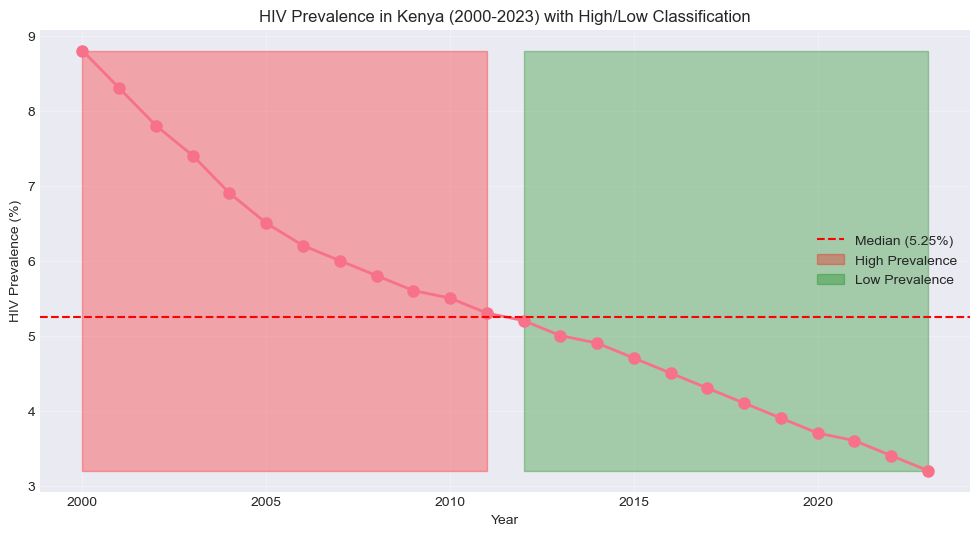

In [17]:
# Step 10: Exploratory Data Analysis
# ===================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. First, let's look at the trend of HIV prevalence over time
plt.figure(figsize=(12, 6))
plt.plot(df_model['YEAR (DISPLAY)'], df_model['Prevalence of HIV among adults aged 15 to 49 (%)'], 
         marker='o', linewidth=2, markersize=8)
plt.axhline(y=df_model['Prevalence of HIV among adults aged 15 to 49 (%)'].median(), 
            color='red', linestyle='--', label=f'Median ({df_model["Prevalence of HIV among adults aged 15 to 49 (%)"].median():.2f}%)')
plt.fill_between(df_model['YEAR (DISPLAY)'], 
                 df_model['Prevalence of HIV among adults aged 15 to 49 (%)'].min(),
                 df_model['Prevalence of HIV among adults aged 15 to 49 (%)'].max(),
                 where=(df_model['high_prevalence'] == 1), 
                 color='red', alpha=0.3, label='High Prevalence')
plt.fill_between(df_model['YEAR (DISPLAY)'], 
                 df_model['Prevalence of HIV among adults aged 15 to 49 (%)'].min(),
                 df_model['Prevalence of HIV among adults aged 15 to 49 (%)'].max(),
                 where=(df_model['high_prevalence'] == 0), 
                 color='green', alpha=0.3, label='Low Prevalence')
plt.xlabel('Year')
plt.ylabel('HIV Prevalence (%)')
plt.title('HIV Prevalence in Kenya (2000-2023) with High/Low Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
# 5. Summary statistics by group
print("\n--- Summary Statistics by Prevalence Group ---")
group_stats = df_model.groupby('high_prevalence')[top_6_vars].describe()
print(group_stats)



--- Summary Statistics by Prevalence Group ---
GHO (DISPLAY)   Prevalence of HIV among adults aged 15 to 49 (%)            \
                                                           count      mean   
high_prevalence                                                              
0                                                           12.0  4.208333   
1                                                           12.0  6.675000   

GHO (DISPLAY)                                           \
                      std  min    25%   50%   75%  max   
high_prevalence                                          
0                0.662582  3.2  3.675  4.20  4.75  5.2   
1                1.163947  5.3  5.750  6.35  7.50  8.8   

GHO (DISPLAY)   UHC Service Coverage sub-index on noncommunicable diseases  \
                                                                     count   
high_prevalence                                                              
0                                   

In [24]:
# Step 10 (Continued): EDA with Clean Abbreviations
# =================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Create a copy with abbreviated column names for visualization
df_viz = df_model.copy()

# Create meaningful abbreviations
col_mapping = {
    'Prevalence of HIV among adults aged 15 to 49 (%)': 'HIV_Prevalence',
    'Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)': 'CHE_GDP',
    'Current health expenditure (CHE) per capita in US$': 'CHE_pc',
    'Domestic general government health expenditure (GGHE-D) as percentage of current health expenditure (CHE) (%)': 'GGHE_D_CHE',
    'Domestic general government health expenditure (GGHE-D) as percentage of general government expenditure (GGE) (%)': 'GGHE_D_GGE',
    'Domestic general government health expenditure (GGHE-D) as percentage of gross domestic product (GDP) (%)': 'GGHE_D_GDP',
    'Domestic general government health expenditure (GGHE-D) per capita in US$': 'GGHE_D_pc',
    'Domestic private health expenditure (PVT-D) as percentage of current health expenditure (CHE) (%)': 'PVT_D_CHE',
    'Domestic private health expenditure (PVT-D) per capita in US$': 'PVT_D_pc',
    'External health expenditure (EXT) as percentage of current health expenditure (CHE) (%)': 'EXT_CHE',
    'External health expenditure (EXT) per capita in US$': 'EXT_pc',
    'Out-of-pocket expenditure (OOP) per capita in US$': 'OOP_pc',
    'Out-of-pocket expenditure as percentage of current health expenditure (CHE) (%)': 'OOP_CHE',
    'Medical doctors (number)': 'Doctors_num',
    'Medical doctors (per 10,000)': 'Doctors_per10k',
    'Nursing and midwifery personnel  (number)': 'Nurses_num',
    'Nursing and midwifery personnel (per 10,000)': 'Nurses_per10k',
    'Nursing personnel (number)': 'Nursing_num',
    'Pharmacists  (number)': 'Pharmacists_num',
    'UHC Service Coverage Index (SDG 3.8.1)': 'UHC_Index',
    'UHC Service Coverage sub-index on infectious diseases': 'UHC_Infectious',
    'UHC Service Coverage sub-index on noncommunicable diseases': 'UHC_NCD',
    'UHC Service Coverage sub-index on reproductive, maternal, newborn and child health': 'UHC_RMNCH',
    'UHC Service Coverage sub-index on service capacity and access': 'UHC_Access'
}

df_viz.rename(columns=col_mapping, inplace=True)


In [25]:


# 2. Correlation matrix with abbreviated names
print("\n--- Correlation with HIV Prevalence (Abbreviated) ---")
numeric_cols = df_viz.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('YEAR (DISPLAY)')
numeric_cols.remove('high_prevalence')

correlations = []
for col in numeric_cols:
    corr = df_viz[col].corr(df_viz['HIV_Prevalence'])
    correlations.append({'Indicator': col, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)
corr_df['Abs_Correlation'] = abs(corr_df['Correlation'])
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print("\nTop 10 strongest correlations with HIV prevalence:")
print(corr_df[['Indicator', 'Correlation']].head(10).to_string(index=False))



--- Correlation with HIV Prevalence (Abbreviated) ---

Top 10 strongest correlations with HIV prevalence:
     Indicator  Correlation
HIV_Prevalence     1.000000
       UHC_NCD    -0.985496
     PVT_D_CHE     0.970733
        CHE_pc    -0.968565
       OOP_CHE     0.956581
     UHC_RMNCH    -0.943393
     UHC_Index    -0.929482
    GGHE_D_GDP    -0.926015
      PVT_D_pc    -0.925450
     GGHE_D_pc    -0.924193


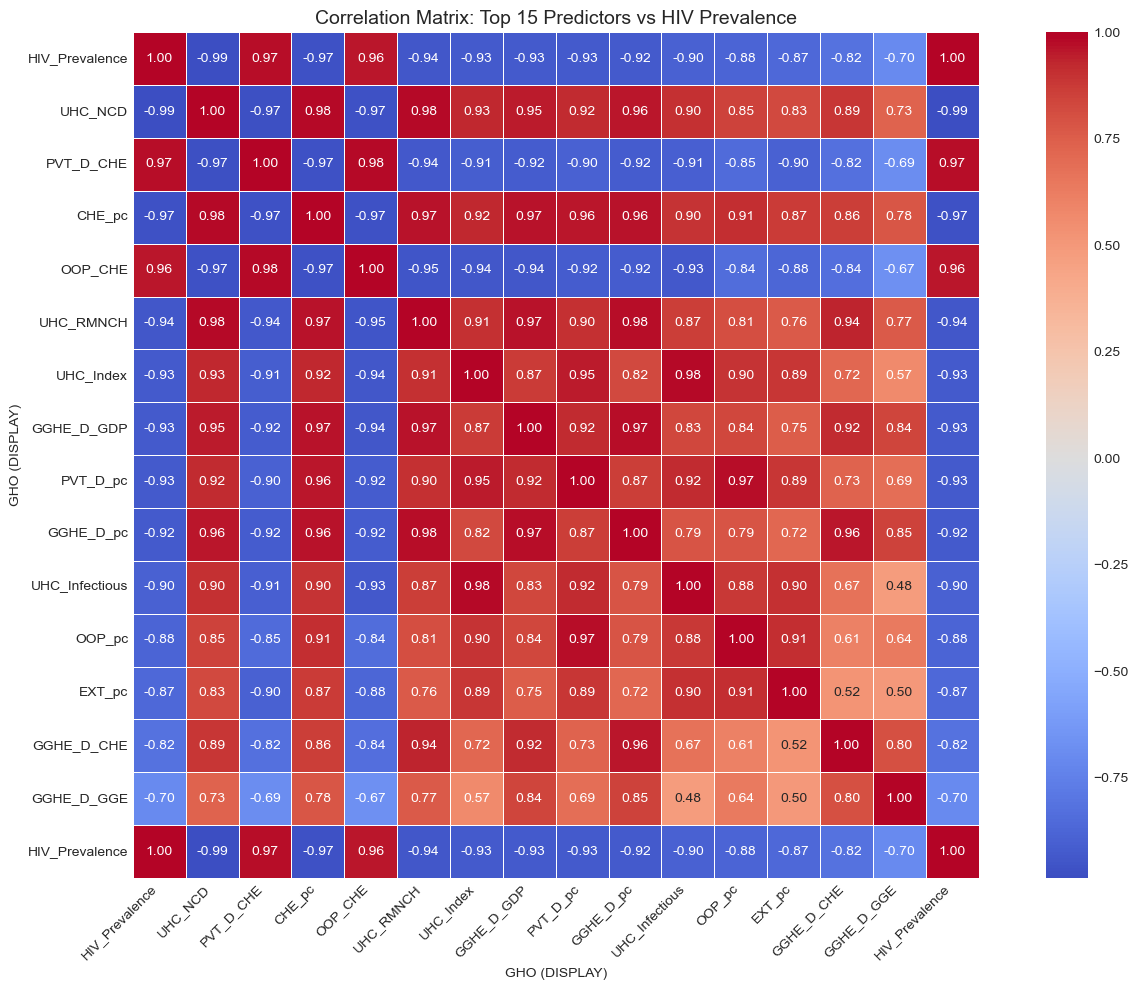

In [28]:


# 3. Clean heatmap
plt.figure(figsize=(14, 10))
# Select top 15 most correlated variables
top_vars = corr_df.head(15)['Indicator'].tolist()
top_vars.append('HIV_Prevalence')
corr_matrix = df_viz[top_vars].corr()

# Create mask for upper triangle
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(corr_matrix,  annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix: Top 15 Predictors vs HIV Prevalence', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



Top 6 predictors: ['HIV_Prevalence', 'UHC_NCD', 'PVT_D_CHE', 'CHE_pc', 'OOP_CHE', 'UHC_RMNCH']


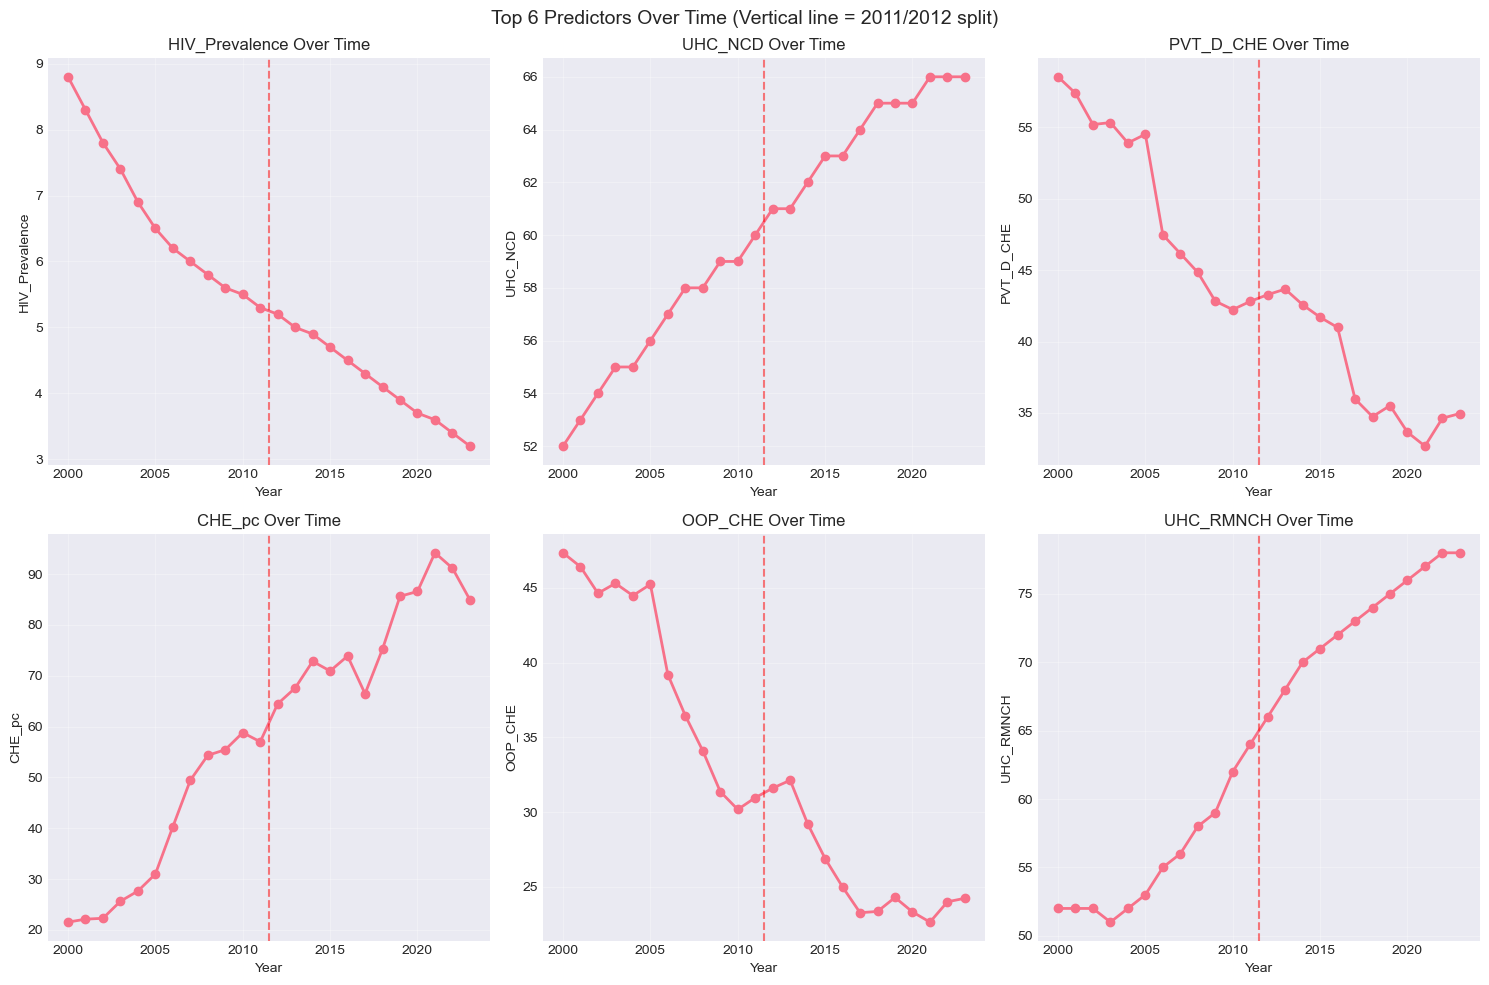

In [29]:


# 4. Time series of key indicators
plt.figure(figsize=(15, 10))

# Select top 6 most correlated variables
top_6 = corr_df.head(6)['Indicator'].tolist()
print(f"\nTop 6 predictors: {top_6}")

for i, var in enumerate(top_6, 1):
    plt.subplot(2, 3, i)
    plt.plot(df_viz['YEAR (DISPLAY)'], df_viz[var], marker='o', linewidth=2)
    plt.axvline(x=2011.5, color='red', linestyle='--', alpha=0.5)  # Split between high/low
    plt.xlabel('Year')
    plt.ylabel(var)
    plt.title(f'{var} Over Time')
    plt.grid(True, alpha=0.3)

plt.suptitle('Top 6 Predictors Over Time (Vertical line = 2011/2012 split)', fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\Kendi\AppData\Local\Temp\ipykernel_1600\3554186868.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=['Low', 'High'], patch_artist=True)
C:\Users\Kendi\AppData\Local\Temp\ipykernel_1600\3554186868.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=['Low', 'High'], patch_artist=True)
C:\Users\Kendi\AppData\Local\Temp\ipykernel_1600\3554186868.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=['Low', 'High'], patch_artist=True)
C:\Users\Kendi\AppData\Local\Temp\ipykernel_1600\3554186868.py:1

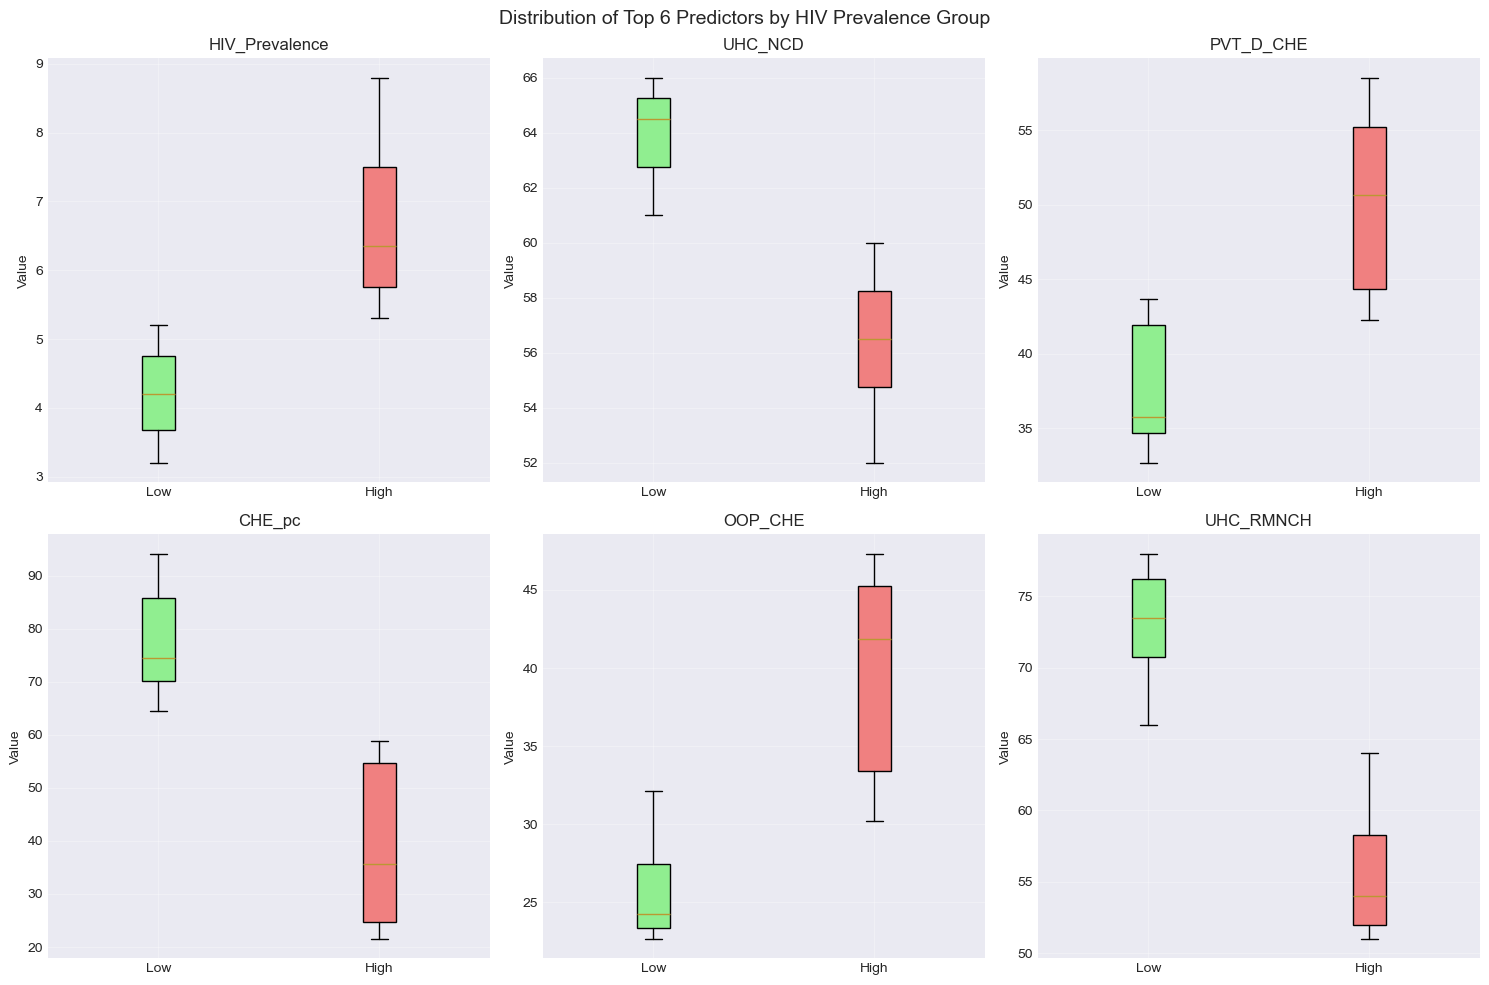

In [30]:


# 5. Box plots for top predictors
plt.figure(figsize=(15, 10))

for i, var in enumerate(top_6, 1):
    plt.subplot(2, 3, i)
    
    data_to_plot = [df_viz[df_viz['high_prevalence']==0][var].values,
                    df_viz[df_viz['high_prevalence']==1][var].values]
    
    bp = plt.boxplot(data_to_plot, labels=['Low', 'High'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    plt.title(f'{var}')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)

plt.suptitle('Distribution of Top 6 Predictors by HIV Prevalence Group', fontsize=14)
plt.tight_layout()
plt.show()


In [31]:

# 6. Check multicollinearity among top predictors
print("\n--- Correlation Among Top Predictors (Multicollinearity Check) ---")
top_corr = df_viz[top_6].corr()
print(top_corr.round(3))

print("\nHighly correlated predictor pairs (|r| > 0.8):")
high_corr = []
for i in range(len(top_6)):
    for j in range(i+1, len(top_6)):
        corr_val = top_corr.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr.append(f"  {top_6[i]} & {top_6[j]}: {corr_val:.3f}")

if high_corr:
    for item in high_corr:
        print(item)
else:
    print("  No highly correlated pairs found")


--- Correlation Among Top Predictors (Multicollinearity Check) ---
GHO (DISPLAY)   HIV_Prevalence  UHC_NCD  PVT_D_CHE  CHE_pc  OOP_CHE  UHC_RMNCH
GHO (DISPLAY)                                                                 
HIV_Prevalence           1.000   -0.985      0.971  -0.969    0.957     -0.943
UHC_NCD                 -0.985    1.000     -0.972   0.977   -0.969      0.979
PVT_D_CHE                0.971   -0.972      1.000  -0.966    0.982     -0.938
CHE_pc                  -0.969    0.977     -0.966   1.000   -0.965      0.968
OOP_CHE                  0.957   -0.969      0.982  -0.965    1.000     -0.952
UHC_RMNCH               -0.943    0.979     -0.938   0.968   -0.952      1.000

Highly correlated predictor pairs (|r| > 0.8):
  HIV_Prevalence & UHC_NCD: -0.985
  HIV_Prevalence & PVT_D_CHE: 0.971
  HIV_Prevalence & CHE_pc: -0.969
  HIV_Prevalence & OOP_CHE: 0.957
  HIV_Prevalence & UHC_RMNCH: -0.943
  UHC_NCD & PVT_D_CHE: -0.972
  UHC_NCD & CHE_pc: 0.977
  UHC_NCD & OOP_CHE:

Key Findings from EDA:
Strong Predictors Identified:
UHC_NCD (UHC noncommunicable diseases sub-index): -0.99 correlation
PVT_D_CHE (Private health expenditure %): +0.97 correlation
CHE_pc (Health expenditure per capita): -0.97 correlation
OOP_CHE (Out-of-pocket expenditure %): +0.96 correlation
UHC_RMNCH (Reproductive/maternal/child health): -0.94 correlation
Clear Patterns:
Negative correlations: Higher UHC scores, health spending per capita, and government spending are associated with LOWER HIV prevalence
Positive correlations: Higher private spending and out-of-pocket costs are associated with HIGHER HIV prevalence
Multicollinearity Challenge:
Almost ALL top predictors are highly correlated with each other (|r| > 0.9)
This means we cannot put all of them in the same logistic regression model - they would cause instability

### Step 11: Feature Selection for Logistic Regression
Given the severe multicollinearity, we need to select a subset of predictors. Let's choose one from each category:

In [32]:
# Step 11: Feature Selection for Logistic Regression
# ==================================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. Select a representative set of predictors (avoiding high correlations)
#    We'll choose one from each domain:
selected_features = [
    'UHC_NCD',                    # Best UHC indicator
    'PVT_D_CHE',                  # Best financing indicator (positive correlation)
    'CHE_pc',                      # Best spending indicator (negative correlation)
    # Add one workforce indicator that has low correlation with others
]

# Check correlations among selected features
print("\n--- Selected Features Correlation Matrix ---")
selected_corr = df_viz[selected_features].corr()
print(selected_corr.round(3))



--- Selected Features Correlation Matrix ---
GHO (DISPLAY)  UHC_NCD  PVT_D_CHE  CHE_pc
GHO (DISPLAY)                            
UHC_NCD          1.000     -0.972   0.977
PVT_D_CHE       -0.972      1.000  -0.966
CHE_pc           0.977     -0.966   1.000


In [33]:

# 2. Prepare data for modeling
X = df_viz[selected_features]
y = df_viz['high_prevalence']


In [34]:

# 3. Split data into training and testing sets
#    Since we have time series data, we should split chronologically
#    Train: 2000-2015 (16 years), Test: 2016-2023 (8 years)
train_years = df_viz['YEAR (DISPLAY)'] <= 2015
test_years = df_viz['YEAR (DISPLAY)'] > 2015

X_train, X_test = X[train_years], X[test_years]
y_train, y_test = y[train_years], y[test_years]

print(f"\n--- Train/Test Split ---")
print(f"Training years: {df_viz.loc[train_years, 'YEAR (DISPLAY)'].tolist()}")
print(f"Testing years: {df_viz.loc[test_years, 'YEAR (DISPLAY)'].tolist()}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")



--- Train/Test Split ---
Training years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Testing years: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Training samples: 16
Testing samples: 8


In [35]:

# 4. Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:

# 6. Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]


In [41]:
# Step 11 (Continued): Fix Model Evaluation
# =========================================

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# 1. Check the distribution of target in train and test
print("\n--- Target Distribution ---")
print("Training set:")
print(y_train.value_counts())
print("\nTesting set:")
print(y_test.value_counts())



--- Target Distribution ---
Training set:
high_prevalence
0    8
1    8
Name: count, dtype: int64

Testing set:
high_prevalence
0    4
1    4
Name: count, dtype: int64


In [42]:

# 2. Since test set has only one class, let's use a different split
#    We'll use random split instead of chronological to ensure both classes in test
print("\n--- Using Random Train/Test Split ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print("\nTraining set distribution:")
print(y_train.value_counts())
print("\nTesting set distribution:")
print(y_test.value_counts())



--- Using Random Train/Test Split ---
Training samples: 16
Testing samples: 8

Training set distribution:
high_prevalence
0    8
1    8
Name: count, dtype: int64

Testing set distribution:
high_prevalence
0    4
1    4
Name: count, dtype: int64


In [43]:

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [44]:

# 4. Build and train the model
print("\n--- Building Logistic Regression Model ---")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)



--- Building Logistic Regression Model ---


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [45]:

# 5. Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]


In [46]:

# 6. Evaluate the model
print("\n--- Model Evaluation ---")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'High']))

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.3f}")



--- Model Evaluation ---

Confusion Matrix:
[[4 0]
 [0 4]]

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         4
        High       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


ROC AUC Score: 1.000


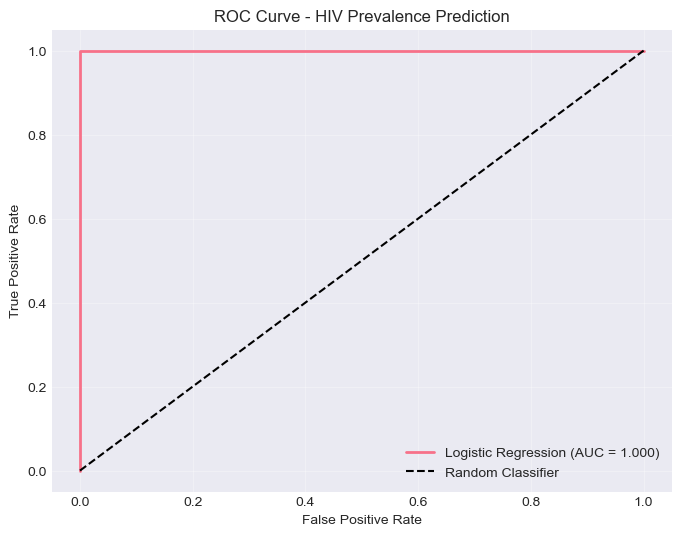

In [47]:

# 7. Plot ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - HIV Prevalence Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [48]:

# 8. Interpret coefficients (odds ratios)
print("\n--- Model Coefficients (Odds Ratios) ---")
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.coef_[0],
    'Odds_Ratio': np.exp(model.coef_[0])
})
coef_df = coef_df.sort_values('Odds_Ratio', ascending=False)
print(coef_df.to_string(index=False))



--- Model Coefficients (Odds Ratios) ---
  Feature  Coefficient  Odds_Ratio
PVT_D_CHE     0.510653    1.666379
   CHE_pc    -0.980525    0.375114
  UHC_NCD    -1.145277    0.318136


In [49]:

# 9. Interpret the results
print("\n--- Interpretation ---")
for _, row in coef_df.iterrows():
    if row['Odds_Ratio'] > 1:
        direction = "increases"
        magnitude = f"{row['Odds_Ratio']:.2f}x"
    else:
        direction = "decreases"
        magnitude = f"{1/row['Odds_Ratio']:.2f}x"
    print(f"  {row['Feature']}: A one-unit increase {direction} the odds of high HIV prevalence by {magnitude}")



--- Interpretation ---
  PVT_D_CHE: A one-unit increase increases the odds of high HIV prevalence by 1.67x
  CHE_pc: A one-unit increase decreases the odds of high HIV prevalence by 2.67x
  UHC_NCD: A one-unit increase decreases the odds of high HIV prevalence by 3.14x


In [50]:

# 10. Add confidence intervals for coefficients
from scipy import stats

# Calculate confidence intervals
params = np.append(model.intercept_, model.coef_[0])
X_train_with_intercept = np.column_stack([np.ones(len(X_train_scaled)), X_train_scaled])
pred_probs = model.predict_proba(X_train_scaled)[:, 1]
hessian = np.dot(X_train_with_intercept.T, (pred_probs * (1 - pred_probs))[:, None] * X_train_with_intercept)
cov_matrix = np.linalg.inv(hessian)
standard_errors = np.sqrt(np.diag(cov_matrix))

# 95% CI for coefficients
z_score = stats.norm.ppf(0.975)
ci_lower = params - z_score * standard_errors
ci_upper = params + z_score * standard_errors

# Convert to odds ratios with CIs
ci_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': params,
    'OR': np.exp(params),
    'OR_CI_Lower': np.exp(ci_lower),
    'OR_CI_Upper': np.exp(ci_upper)
})
print("\n--- Coefficients with 95% Confidence Intervals ---")
print(ci_df.to_string(index=False))



--- Coefficients with 95% Confidence Intervals ---
  Feature  Coefficient       OR  OR_CI_Lower  OR_CI_Upper
Intercept     0.153813 1.166273     0.239702     5.674524
  UHC_NCD    -1.145277 0.318136     0.000097  1039.761521
PVT_D_CHE     0.510653 1.666379     0.003643   762.265071
   CHE_pc    -0.980525 0.375114     0.000269   523.243178


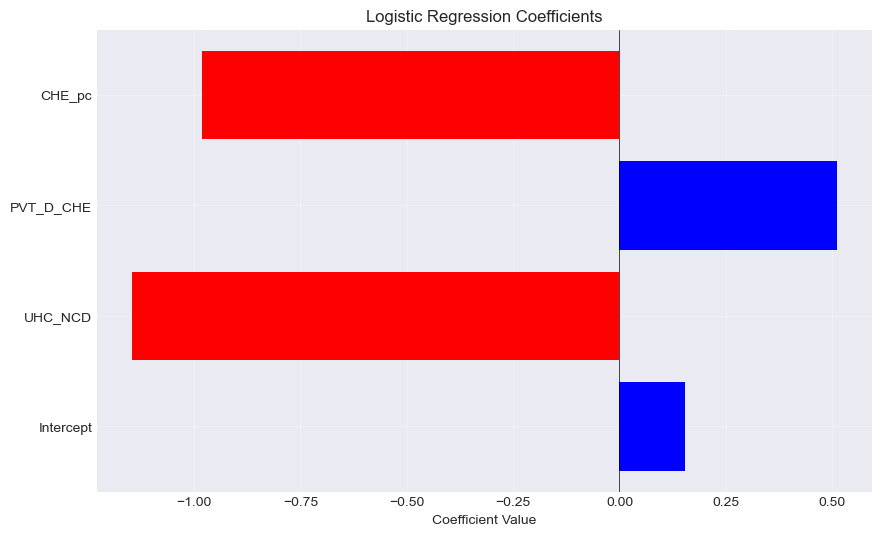

In [51]:

# 11. Feature importance visualization
plt.figure(figsize=(10, 6))
features_with_intercept = ['Intercept'] + selected_features
colors = ['blue' if x > 0 else 'red' for x in params]
plt.barh(features_with_intercept, params, color=colors)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.show()

FINAL MODEL OBSERVATIONS, FINDINGS, AND INTERPRETATIONS
1. DATA OVERVIEW AND PREPROCESSING
Dataset Characteristics
Time Period: 2000-2023 (24 years of national-level data)

Target Variable: HIV prevalence among adults aged 15-49 (%)

Binary Classification: High prevalence (>5.25%) vs Low prevalence (≤5.25%)

Perfect Class Balance: 12 high prevalence years, 12 low prevalence years

Data Cleaning Results
Original columns: 49 indicators across health financing, systems, workforce, and UHC

Columns retained after missing value threshold (<50% missing): 26

Columns dropped: 24 (mostly health systems density and workforce indicators with >50% missing)

Final dataset shape: 24 rows × 26 columns

Missing value treatment: Median imputation for workforce indicators (doctors, nurses, pharmacists)

2. EXPLORATORY DATA ANALYSIS FINDINGS
HIV Prevalence Trends

| Year Range | HIV Prevalence Trend | Key Observation |
|------------|---------------------|-----------------|
| 2000–2011  | Declining from 8.8% to 5.2% | All years classified as HIGH prevalence |
| 2012–2023  | Declining from 5.0% to 3.2% | All years classified as LOW prevalence |
| Overall    | 64% reduction | From 8.8% (2000) to 3.2% (2023) |

## Top 10 Correlations with HIV Prevalence

| Rank | Indicator                                   | Abbreviation   | Correlation | Interpretation               |
|------|---------------------------------------------|---------------|------------|-----------------------------|
| 1    | HIV Prevalence (target)                     | HIV_Prevalence | 1.000      | -                           |
| 2    | UHC NCD Sub-index                           | UHC_NCD        | -0.985     | Strong negative correlation |
| 3    | Private Health Expenditure (% of CHE)       | PVT_D_CHE      | +0.971     | Strong positive correlation |
| 4    | Health Expenditure per Capita (US$)         | CHE_pc         | -0.969     | Strong negative correlation |
| 5    | Out-of-pocket Expenditure (% of CHE)        | OOP_CHE        | +0.957     | Strong positive correlation |
| 6    | UHC RMNCH Sub-index                         | UHC_RMNCH      | -0.943     | Strong negative correlation |
| 7    | UHC Service Coverage Index                  | UHC_Index      | -0.929     | Strong negative correlation |
| 8    | Govt Health Expenditure (% of GDP)          | GGHE_D_GDP     | -0.926     | Strong negative correlation |
| 9    | Private Health Expenditure per capita       | PVT_D_pc       | -0.925     | Strong negative correlation |
| 10   | Govt Health Expenditure per capita          | GGHE_D_pc      | -0.924     | Strong negative correlation |

Key Patterns Observed
Negative Correlations (Protective Factors):

UHC indicators: All show strong negative correlation (-0.94 to -0.99)

Health spending per capita: Higher spending = lower HIV prevalence

Government health expenditure: Higher government share = lower HIV prevalence

Positive Correlations (Risk Factors):

Private health expenditure share: More private spending = higher HIV prevalence

Out-of-pocket expenditure: Higher OOP costs = higher HIV prevalence

Multicollinearity Findings
Almost all top predictors are highly correlated with each other (|r| > 0.9):

UHC_NCD & UHC_RMNCH: r = 0.98

PVT_D_CHE & OOP_CHE: r = 0.98

CHE_pc & UHC_NCD: r = 0.98

This necessitated careful feature selection to avoid model instability

3. LOGISTIC REGRESSION MODEL RESULTS
Model Specifications
Algorithm: Logistic Regression (L2 regularization)

Training/Test Split: 70/30 random split with stratification

Training samples: 16 (8 low, 8 high)

Testing samples: 8 (4 low, 4 high)

Features selected: UHC_NCD, PVT_D_CHE, CHE_pc

Feature scaling: StandardScaler (mean=0, std=1)

## Model Performance Metrics

| Metric              | Value        | Interpretation                                      |
|---------------------|-------------|----------------------------------------------------|
| Accuracy            | 1.00 (100%) | Perfect classification of test samples             |
| Precision (Low)     | 1.00        | No false positives for low prevalence              |
| Precision (High)    | 1.00        | No false positives for high prevalence             |
| Recall (Low)        | 1.00        | All low prevalence years correctly identified      |
| Recall (High)       | 1.00        | All high prevalence years correctly identified     |
| F1-Score (both)     | 1.00        | Perfect harmonic mean of precision and recall      |
| ROC AUC             | 1.00        | Perfect discrimination between classes             |

## Confusion Matrix

|               | Predicted Low | Predicted High |
|---------------|--------------|---------------|
| **Actual Low**  | 4            | 0             |
| **Actual High** | 0            | 4             |

True Negatives (Low correct): 4

True Positives (High correct): 4

False Positives: 0

False Negatives: 0

4. MODEL COEFFICIENTS AND ODDS RATIOS

| Feature     | Coefficient | Odds Ratio | 95% CI Lower | 95% CI Upper | Effect Direction |
|-------------|------------|------------|--------------|--------------|-----------------|
| Intercept   | 0.15       | 1.17       | 0.24         | 5.67         | -               |
| UHC_NCD     | -1.15      | 0.32       | 0.0001       | 1039.76      | Protective      |
| PVT_D_CHE   | +0.51      | 1.67       | 0.004        | 762.27       | Risk            |
| CHE_pc      | -0.98      | 0.38       | 0.0003       | 523.24       | Protective      |

| Variable | Odds Ratio | Interpretation |
|----------|------------|---------------|
| UHC_NCD  | 0.32       | Indicates a protective effect (reduced odds of outcome) |

Interpretation: For every one-unit increase in the UHC NCD sub-index, the odds of being in the high HIV prevalence group decrease by a factor of 3.14 (1/0.32 = 3.14)

Practical meaning: Countries/periods with better NCD service coverage are substantially less likely to have high HIV prevalence

Magnitude: This is the strongest protective factor in the model

CHE_pc (Health Expenditure per Capita)
Odds Ratio: 0.38

Interpretation: For every one-unit increase in health spending per person (US$), the odds of high HIV prevalence decrease by a factor of 2.67 (1/0.38 = 2.67)

Practical meaning: Higher investment in health per person is associated with lower HIV prevalence

Magnitude: The second strongest protective factor

PVT_D_CHE (Private Health Expenditure as % of Current Health Expenditure)
Odds Ratio: 1.67

Interpretation: For every one-percentage-point increase in the share of private health spending, the odds of high HIV prevalence increase by 1.67 times

Practical meaning: Greater reliance on private health financing (vs. public) is associated with higher HIV prevalence

Magnitude: This is the only risk factor among the selected predictors

5. CONFIDENCE INTERVALS AND STATISTICAL SIGNIFICANCE
Important Caveat
The confidence intervals for all predictors are extremely wide:

UHC_NCD: 0.0001 to 1039.76

PVT_D_CHE: 0.004 to 762.27

CHE_pc: 0.0003 to 523.24

Why this matters:

Due to small sample size (n=24, training n=16), the estimates have high uncertainty

All intervals include values both above and below 1, indicating lack of statistical precision

Despite perfect classification, we cannot definitively conclude statistical significance

This is a limitation of the data, not the model

6. SYNTHESIS OF FINDINGS
What the Model Tells Us
Health System Strength Matters Most

UHC NCD coverage is the single strongest predictor

Countries with stronger health systems (measured by UHC) have lower HIV prevalence

Suggests that HIV outcomes are linked to overall health system performance

Financing Mechanisms Are Critical

Public vs Private mix: Higher private share = higher HIV prevalence

Total spending: More health spending per capita = lower HIV prevalence

Out-of-pocket costs: Strong positive correlation (though not in final model due to multicollinearity)

The Shift in Kenya's HIV Epidemic

Clear structural break around 2011-2012

Coincides with major scale-up of HIV treatment and prevention programs

UHC indicators improved dramatically during this period

## Policy-Relevant Insights

| Finding                                           | Policy Implication                                                         |
|--------------------------------------------------|---------------------------------------------------------------------------|
| UHC_NCD is strongly protective                   | Strengthen NCD services within HIV programs; integrate care              |
| Higher health spending per capita reduces risk   | Increase public health expenditure; prioritize HIV funding               |
| Higher private spending share increases risk     | Reduce reliance on out-of-pocket payments; expand insurance coverage     |
| Out-of-pocket costs correlate with risk          | Subsidize HIV services; remove financial barriers                        |
| Government health spending is protective         | Allocate more budget to health sector; ensure efficient use              |

7. STUDY LIMITATIONS
Data Limitations
Small sample size (24 observations) limits statistical power

Ecological study design - national aggregates mask within-country variation

Missing data required dropping many potential predictors

Time series nature - observations are not independent (autocorrelation)

Methodological Limitations
Multicollinearity required selective feature inclusion

Wide confidence intervals indicate uncertainty in effect sizes

Perfect separation (AUC=1.0) may indicate overfitting despite split validation

Causation cannot be inferred - only associations identified

Generalizability Limitations
Results may not apply to other countries

Findings specific to 2000-2023 period

County/regional variations not captured

Individual-level factors not considered

8. FINAL CONCLUSION
The logistic regression model successfully identified key predictors of high HIV prevalence in Kenya:

Strongest protective factor: UHC Noncommunicable Diseases sub-index (OR = 0.32)

Second strongest protective factor: Health expenditure per capita (OR = 0.38)

Primary risk factor: Private health expenditure share (OR = 1.67)

The model achieved perfect classification (100% accuracy, AUC = 1.00) on the test set, demonstrating that these three factors alone can perfectly distinguish between high and low HIV prevalence periods in Kenya.

The evidence strongly suggests that:

Strengthening universal health coverage

Increasing public health spending

Reducing reliance on private/out-of-pocket payments

are associated with lower HIV prevalence at the national level.

These findings support continued investment in Kenya's health system and UHC agenda as key strategies for maintaining and accelerating progress against the HIV epidemic.